<a href="https://colab.research.google.com/github/adnan119/Pytorch-Projects/blob/main/ResNet/w%26b_train_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd drive/My Drive/Pytorch-Projects/ResNet

/content/drive/My Drive/Pytorch-Projects/ResNet


In [4]:
!pip install wandb
!wandb login

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 139 kB 48.7 MB/s 
     |████████████████████████████████| 180 kB 47.0 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=00414e906eb889d903d447434c3b4e2d2b186cc6e942eef8dc054df58e9e1dfd
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=f078dde4b1f9a9cbaf047fbfe47e0d5d6f386dee151653f1b1404c76b09417fc
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wan

In [5]:
# from copy_resnet import test_1
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

from resnet import ResNet101

import wandb

In [6]:
wandb.init(project="training-resnet-101")

wandb: Currently logged in as: adnanpen (use `wandb login --relogin` to force relogin)


# **1.Loading Dataset**

In [8]:
#defining transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #  transforms.CenterCrop(100),
    #  transforms.RandomPerspective(p=0.5),
     transforms.RandomHorizontalFlip(p=0.5)])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
)

In [9]:
#defining dataset and dataloaders

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


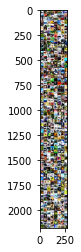

plane   car   cat  frog


In [10]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


# **2. Defining the model**

In [11]:
resume = False

In [12]:
model = ResNet101()
if resume:
  checkpoint = torch.load('r101_cifar10.pt')
  model.load_state_dict(checkpoint)
model.cuda()
params = list(model.parameters())
print(len(params))
print(params[17].size())

351
torch.Size([64, 256, 1, 1])


In [ ]:
print(model)

# **3. Loss function and optimizer**

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
lrsheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [15]:
wandb.watch(model, criterion, log="all", log_freq=10)

[]

In [7]:
wandb.config = {"learning_rate": 0.1, "epochs": 25, "batch_size": 512, 'lr_scheduler': "StepLR", "step_size":20}

# **4. Train the network**

In [17]:
epochs = 25
test_loss_min = np.Inf
test_loss = 0
total = 0
correct = 0

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    print(lrsheduler.get_lr())
    model.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i+1 % 2000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            wandb.log({"epoch": epoch, "loss": running_loss / 2000})
            running_loss = 0.0

    model.eval()
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()*inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    lrsheduler.step()
    test_loss = test_loss/len(testloader.dataset)
    _correct = (correct*100)/total
    wandb.log({"test_accuracy": _correct, "test_loss": test_loss})


    print('Epoch: {} \tTest Loss: {:.6f} \tAccuracy: {:.6f}'.format(
        epoch, test_loss, _correct))
    
    if test_loss <= test_loss_min:
        print('test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        test_loss))
        
    #to save the check-points
        
        torch.save(model.state_dict(), 'r101_cifar10.pt')
        test_loss_min = test_loss
    


print('Finished Training')

[0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 	Test Loss: 2.836526 	Accuracy: 11.000000
test loss decreased (inf --> 2.836526).  Saving model ...
[0.1]
Epoch: 1 	Test Loss: 2.014956 	Accuracy: 15.240000
test loss decreased (2.836526 --> 2.014956).  Saving model ...
[0.1]
Epoch: 2 	Test Loss: 1.891245 	Accuracy: 18.456667
test loss decreased (2.014956 --> 1.891245).  Saving model ...
[0.1]
Epoch: 3 	Test Loss: 1.640497 	Accuracy: 23.535000
test loss decreased (1.891245 --> 1.640497).  Saving model ...
[0.1]
Epoch: 4 	Test Loss: 1.486815 	Accuracy: 27.892000
test loss decreased (1.640497 --> 1.486815).  Saving model ...
[0.1]
Epoch: 5 	Test Loss: 1.384226 	Accuracy: 31.460000
test loss decreased (1.486815 --> 1.384226).  Saving model ...
[0.1]
Epoch: 6 	Test Loss: 1.338214 	Accuracy: 34.380000
test loss decreased (1.384226 --> 1.338214).  Saving model ...
[0.1]
Epoch: 7 	Test Loss: 1.335864 	Accuracy: 36.606250
test loss decreased (1.338214 --> 1.335864).  Saving model ...
[0.1]
Epoch: 8 	Test Loss: 1.778372 	Accuracy: 37.3

# **5. Testing the network**